In [221]:
import xarray as xr
import numpy as np
from PIL import Image as PILImage
from osgeo import gdal, osr, gdal_array
import netCDF4
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyproj
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg

import shapely.geometry as geometry
import matplotlib.cm as cm
# import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from matplotlib import colors

from descartes import PolygonPatch
def plot_polygon(ax,polygon):
    margin = .3
    x_min, y_min, x_max, y_max = polygon.bounds
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [182]:
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
from shapely.geometry import MultiPoint
from shapely.ops import triangulate
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges,edge_points, coords, pi, pj):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
    """
        #if (pi, pj) in edges or (pj, pi) in edges:
            # already added
        #    return
        #edges.add( (pi, pj) )
        edge_points.append( [pi, pj] )
    multi_points=MultiPoint(points)
    triangles = triangulate(multi_points)
    tri = [np.array(triangle.exterior.coords.xy)[:,:3].T for triangle in triangles]
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for pa, pb, pc in tri:
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, pa, pb)
            add_edge(edges, edge_points, coords, pb, pc)
            add_edge(edges, edge_points, coords, pc, pa)
    m = geometry.MultiLineString(edge_points)
    new_triangles = list(polygonize(m))
    return cascaded_union(new_triangles), edge_points

In [231]:
PMS = gdal.Open('./data/PMS_reference_infra_rouge.tif')
red = np.array(PMS.GetRasterBand(1).ReadAsArray())
blue = np.array(PMS.GetRasterBand(2).ReadAsArray())
green = np.array(PMS.GetRasterBand(3).ReadAsArray())
infra = np.array(PMS.GetRasterBand(4).ReadAsArray())

In [230]:
kmeans_5class = gdal.Open('./data/kmeans_with_altitude/KMeansClass_5classe.tif')
classe_kmeans5 = np.array(kmeans_5class.GetRasterBand(1).ReadAsArray())

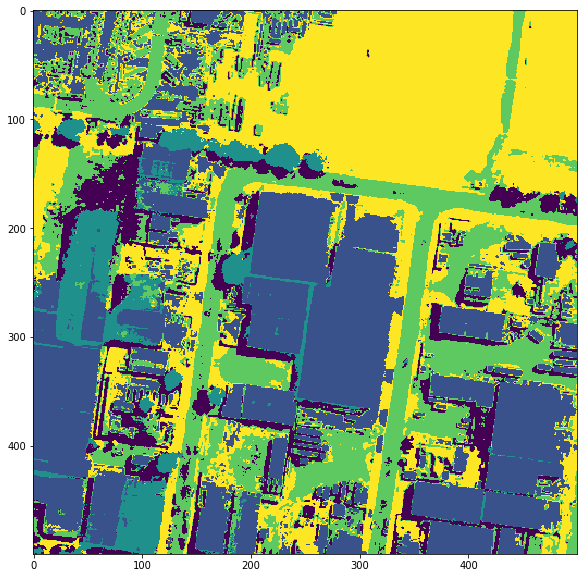

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(classe_kmeans5)
plt.show()

In [77]:
#importer netcdf
data=xr.open_dataset('./data/cloud3D_image.nc')
cloud3D = np.array(data.coord_ECEF)
shape_image=np.shape(cloud3D[0])
x = cloud3D[0]
y = cloud3D[1]
z = cloud3D[2]

#Convertir de ECEF en UTM
ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
utm = pyproj.Proj(proj='utm', ellps='WGS84', datum='WGS84')
p = pyproj.transform(ecef, utm, x, y, z, radians=True)


utm_zero = pyproj.transform(ecef, utm, 0, 0, 0, radians=True)


In [54]:
def blanks(x,y,z):
    return np.where(x==0) and np.where(y==0) and np.where(z==0)

In [109]:
def mask(x,y,z):
    return np.where(x!=0) and np.where(y!=0) and np.where(z!=0)

In [85]:
np.array(p)[:,blanks(x,y,z)[0],blanks(x,y,z)[1]]

array([[  500000.        ,   500000.        ,   500000.        , ...,
          500000.        ,   500000.        ,   500000.        ],
       [ 9997964.943021  ,  9997964.943021  ,  9997964.943021  , ...,
         9997964.943021  ,  9997964.943021  ,  9997964.943021  ],
       [-6356752.31424518, -6356752.31424518, -6356752.31424518, ...,
        -6356752.31424518, -6356752.31424518, -6356752.31424518]])

In [107]:
np.array(p)[:,mask(x,y,z)[0],mask(x,y,z)[1]]

array([[ 3.36421486e+06,  3.36421420e+06,  3.36421420e+06, ...,
         3.36385664e+06,  3.36385664e+06,  3.36385554e+06],
       [-1.52928251e+07, -1.52928259e+07, -1.52928259e+07, ...,
        -1.52926671e+07, -1.52926671e+07, -1.52926677e+07],
       [ 6.80429259e+01,  6.69752988e+01,  6.69752988e+01, ...,
         5.96363901e+01,  5.96363901e+01,  6.15414744e+01]])

In [112]:
classe_kmeans5[mask(x,y,z)[0],mask(x,y,z)[1]]

array([1, 1, 1, ..., 3, 3, 3], dtype=uint8)

In [274]:
lon,lat,alt=np.array(p)[:,mask(x,y,z)[0],mask(x,y,z)[1]]
red_masked=red[mask(x,y,z)[0],mask(x,y,z)[1]]
blue_masked=blue[mask(x,y,z)[0],mask(x,y,z)[1]]
green_masked=green[mask(x,y,z)[0],mask(x,y,z)[1]]
infra_masked=infra[mask(x,y,z)[0],mask(x,y,z)[1]]

In [235]:
classe=1
seg_red=red[mask(x,y,z)[0],mask(x,y,z)[1]][classe_kmeans5[mask(x,y,z)[0],mask(x,y,z)[1]]==classe]
seg_blue=blue[mask(x,y,z)[0],mask(x,y,z)[1]][classe_kmeans5[mask(x,y,z)[0],mask(x,y,z)[1]]==classe]
seg_green=green[mask(x,y,z)[0],mask(x,y,z)[1]][classe_kmeans5[mask(x,y,z)[0],mask(x,y,z)[1]]==classe]
seg_infra=infra[mask(x,y,z)[0],mask(x,y,z)[1]][classe_kmeans5[mask(x,y,z)[0],mask(x,y,z)[1]]==classe]

In [216]:
def plot_lon_lat_by_classe(classe):
    seg_lon = lon[classe_kmeans5[mask(x,y,z)[0],mask(x,y,z)[1]]==classe]
    seg_lat = lat[classe_kmeans5[mask(x,y,z)[0],mask(x,y,z)[1]]==classe]
    seg_alt = alt[classe_kmeans5[mask(x,y,z)[0],mask(x,y,z)[1]]==classe]
    plt.figure(figsize=(10,10))
    plt.plot(-seg_lon,-seg_lat,'o',markersize=0.3)
    plt.show()
    return seg_lon, seg_lat,seg_alt

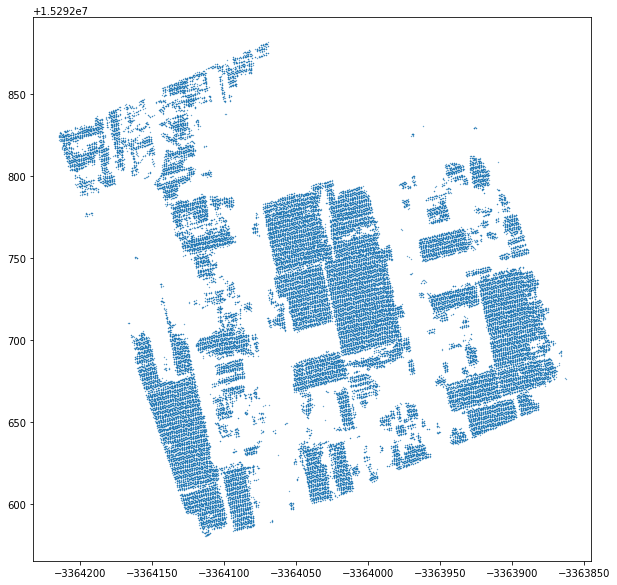

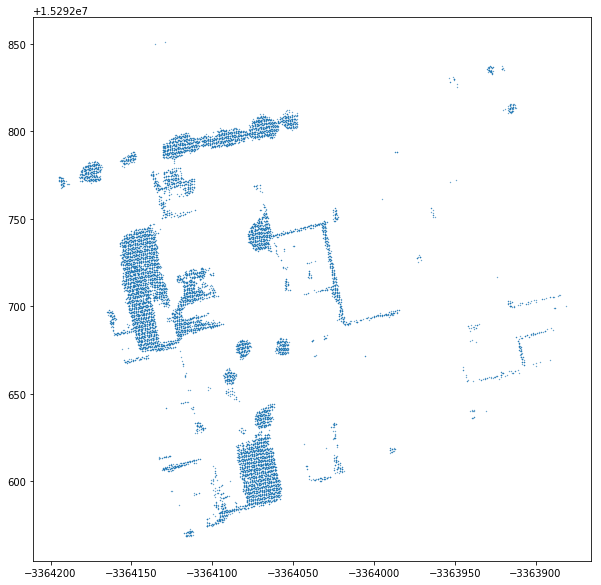

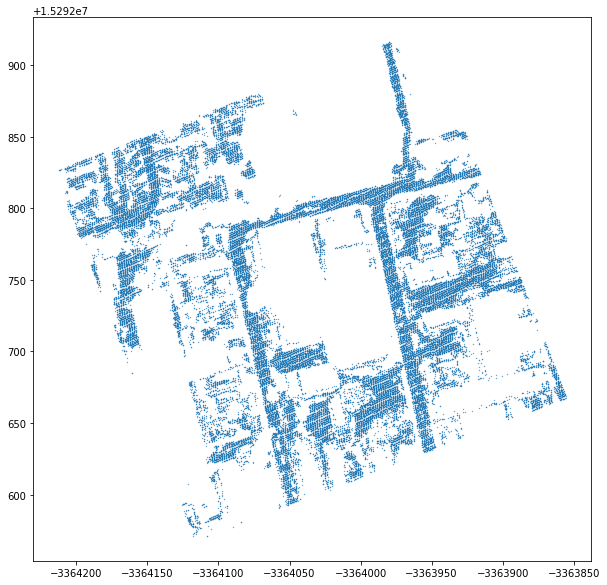

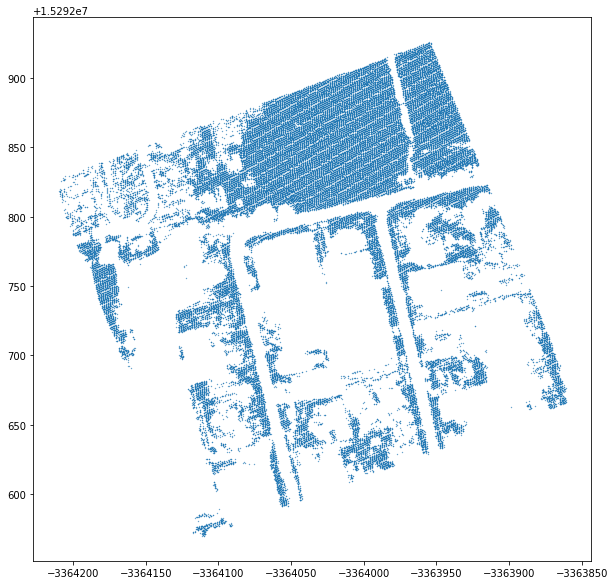

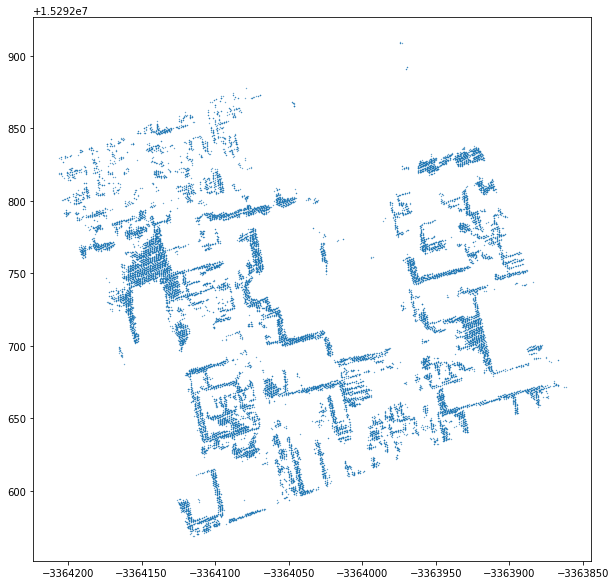

In [217]:
seg_lon, seg_lat,seg_alt = plot_lon_lat_by_classe(1)
_,_,_ = plot_lon_lat_by_classe(2)
_,_,_ = plot_lon_lat_by_classe(3)
_,_,_ = plot_lon_lat_by_classe(4)
_,_,_ = plot_lon_lat_by_classe(0)

In [ ]:
from sklearn.cluster import DBSCAN

In [304]:
#Parameters
threshold=50
#epsilon = 1/58.609
epsilon = 17
coords=np.concatenate(([seg_lon],[seg_lat],[seg_alt],[seg_red],[seg_blue],[seg_green],[seg_infra])).T
#DBSCAN
db = DBSCAN(eps= epsilon, min_samples=1).fit(coords)
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
len_clusters=np.array([len(np.where(cluster_labels==i)[0]) for i in range(num_clusters)])
i_clusters=np.where(len_clusters>=threshold)[0]
num_clusters_cleaned=len(i_clusters)
coords_clusters=[coords[np.where(i==cluster_labels)[0]] for i in i_clusters]

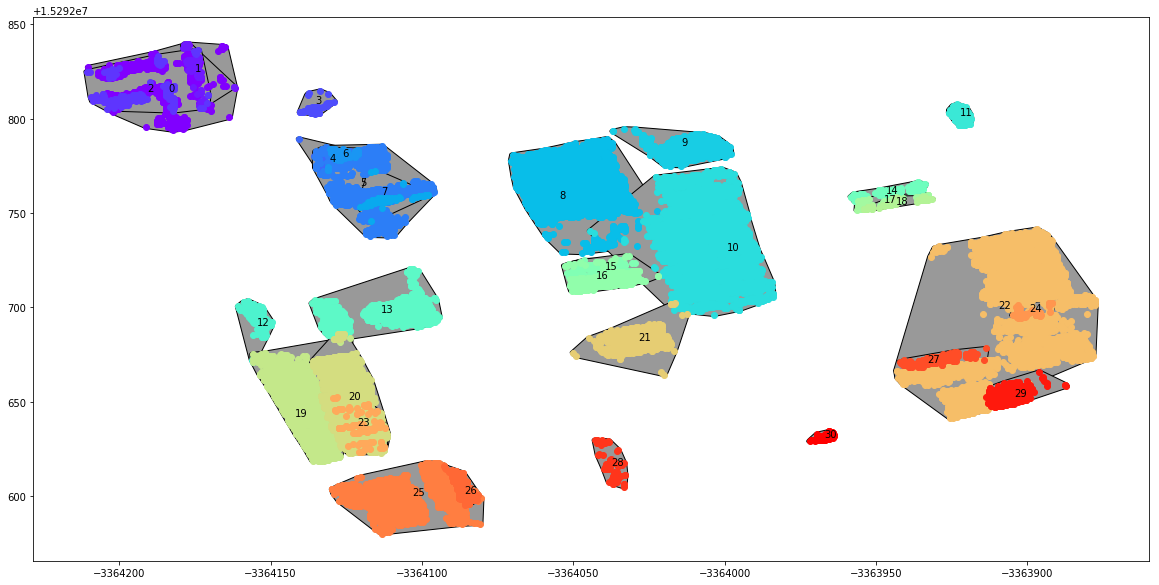

In [305]:
colors=cm.rainbow(np.linspace(0, 1, num_clusters_cleaned))
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
Polygons=[]
for i in range(num_clusters_cleaned):
    plt.scatter(-coords_clusters[i][:,0],-coords_clusters[i][:,1],color=colors[i])
    concave_hull, edge_points = alpha_shape(-coords_clusters[i][:,0:2],alpha=0.01)
    polygon_coords=np.array(concave_hull.exterior.coords.xy)[:,:].T
    #plt.plot(polygon_coords[:,0],polygon_coords[:,1],'or')
    Polygons.append(polygon_coords)
    plot_polygon(ax,concave_hull.buffer(1))
    #Text annotation
    polygon_coords=np.array(concave_hull.exterior.coords.xy)[:,:].T
    xann,yann=np.mean(polygon_coords[:,0]),np.mean(polygon_coords[:,1])
    plt.annotate(str(i),(xann,yann))
plt.show()

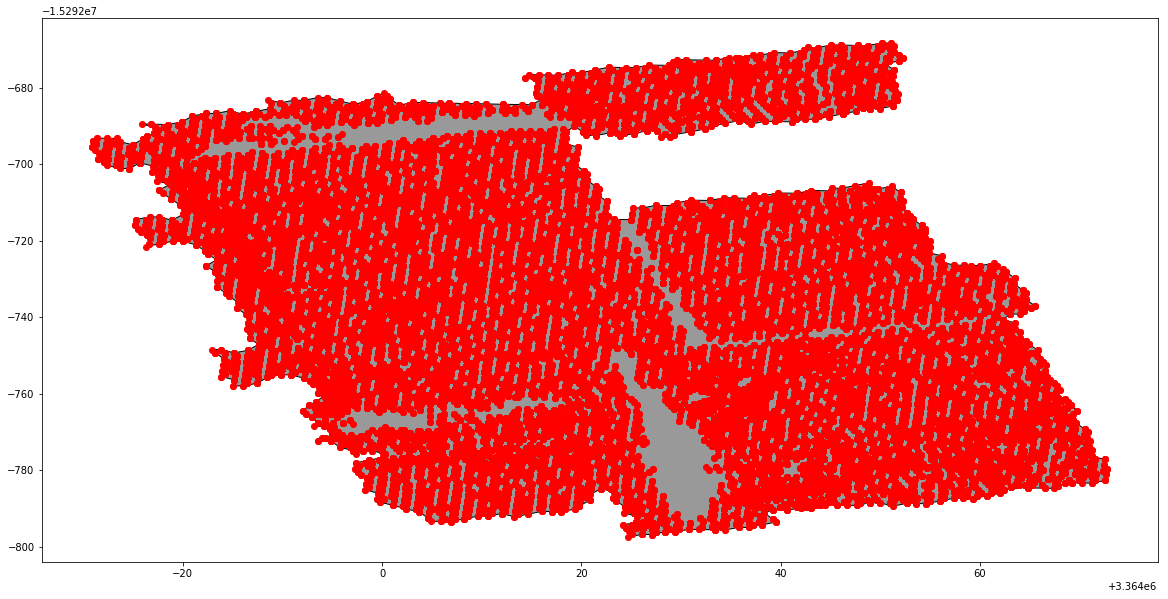

In [187]:
i=30
colors=cm.rainbow(np.linspace(0, 1, num_clusters_cleaned))
new_points=coords_clusters[i]
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
i=5
concave_hull, edge_points = alpha_shape(new_points,alpha=1)
plot_polygon(ax,concave_hull)
#plt.plot(new_points[:,0],new_points[:,1],'o')
plt.plot(np.array(edge_points)[:,0][:,0],np.array(edge_points)[:,0][:,1],'or')
plt.show()

Essai sur Kmeans

In [297]:
from sklearn.cluster import KMeans
coords=np.concatenate(([lon],[lat],[alt],[red_masked],[blue_masked],[green_masked],[infra_masked])).T
kmeans15 = KMeans(n_clusters=15, random_state=0).fit(coords)

In [298]:
cluster_labels = kmeans15.labels_
num_clusters = len(set(cluster_labels))
len_clusters=np.array([len(np.where(cluster_labels==i)[0]) for i in range(num_clusters)])
i_clusters=np.where(len_clusters>=threshold)[0]
num_clusters_cleaned=len(i_clusters)
coords_clusters=[coords[np.where(i==cluster_labels)[0]] for i in i_clusters]

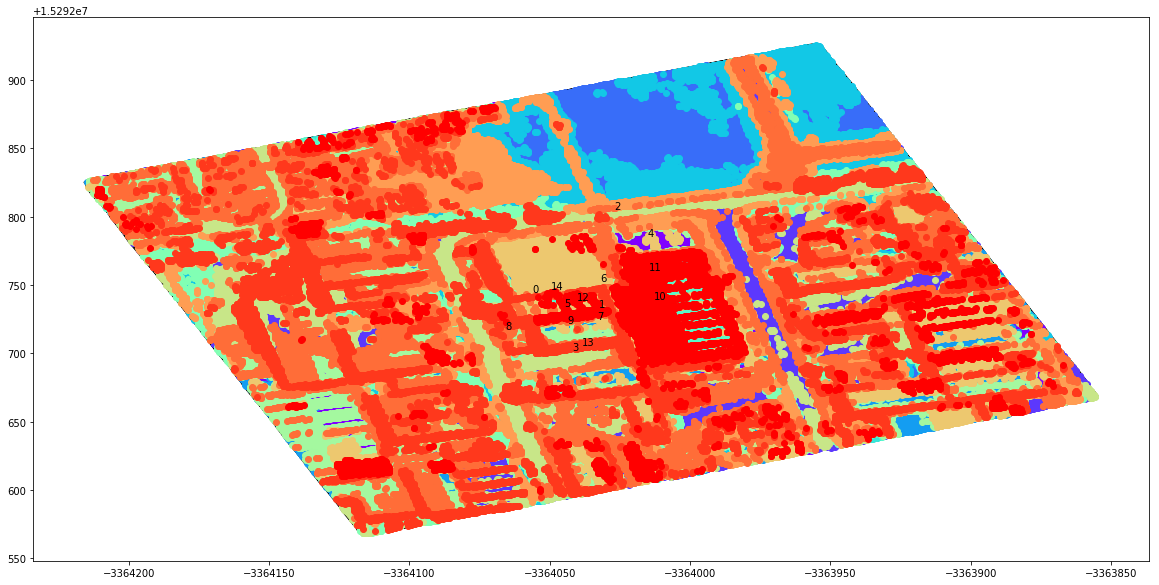

In [299]:
colors=cm.rainbow(np.linspace(0, 1, num_clusters_cleaned))
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
Polygons=[]
for i in range(num_clusters_cleaned):
    plt.scatter(-coords_clusters[i][:,0],-coords_clusters[i][:,1],color=colors[i])
    concave_hull, edge_points = alpha_shape(-coords_clusters[i][:,0:2],alpha=0.01)
    polygon_coords=np.array(concave_hull.exterior.coords.xy)[:,:].T
    #plt.plot(polygon_coords[:,0],polygon_coords[:,1],'or')
    Polygons.append(polygon_coords)
    plot_polygon(ax,concave_hull.buffer(1))
    #Text annotation
    polygon_coords=np.array(concave_hull.exterior.coords.xy)[:,:].T
    xann,yann=np.mean(polygon_coords[:,0]),np.mean(polygon_coords[:,1])
    plt.annotate(str(i),(xann,yann))
plt.show()

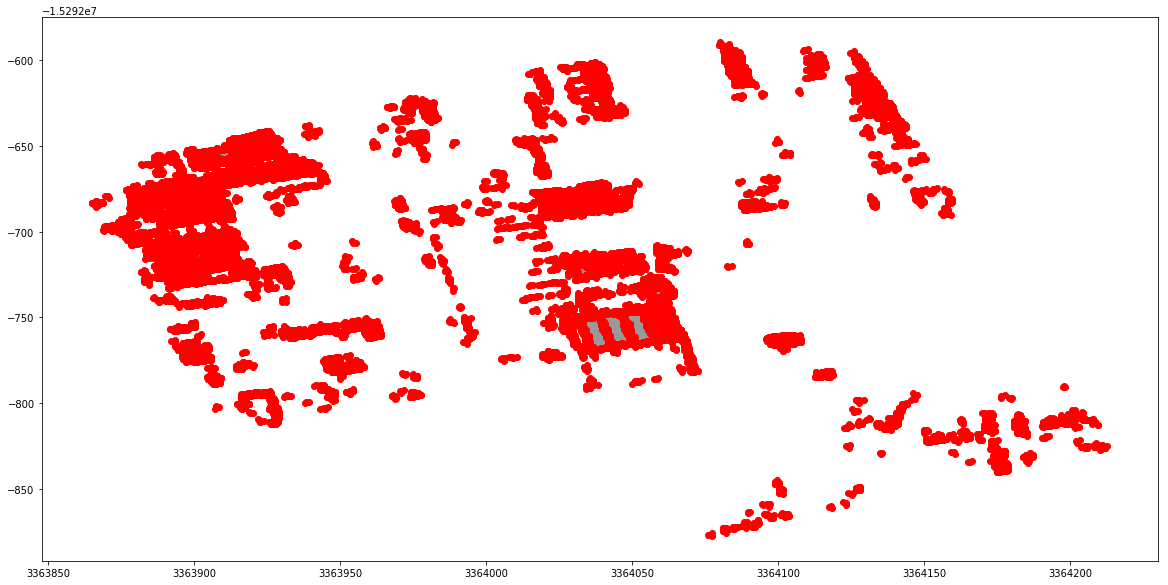

In [303]:
i=3
colors=cm.rainbow(np.linspace(0, 1, num_clusters_cleaned))
new_points=coords_clusters[i][:,0:2]
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
i=5
concave_hull, edge_points = alpha_shape(new_points,alpha=1)
plot_polygon(ax,concave_hull)
#plt.plot(new_points[:,0],new_points[:,1],'o')
plt.plot(np.array(edge_points)[:,0][:,0],np.array(edge_points)[:,0][:,1],'or')
plt.show()

Resultat obtenu en faisant un dbscan sur toutes les données

In [276]:
#Parameters
threshold=50
#epsilon = 1/58.609
epsilon = 17
coords=np.concatenate(([lon],[lat],[alt],[red_masked],[blue_masked],[green_masked],[infra_masked])).T
#DBSCAN
db = DBSCAN(eps= epsilon, min_samples=1).fit(coords)
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
len_clusters=np.array([len(np.where(cluster_labels==i)[0]) for i in range(num_clusters)])
i_clusters=np.where(len_clusters>=threshold)[0]
num_clusters_cleaned=len(i_clusters)
coords_clusters=[coords[np.where(i==cluster_labels)[0]] for i in i_clusters]

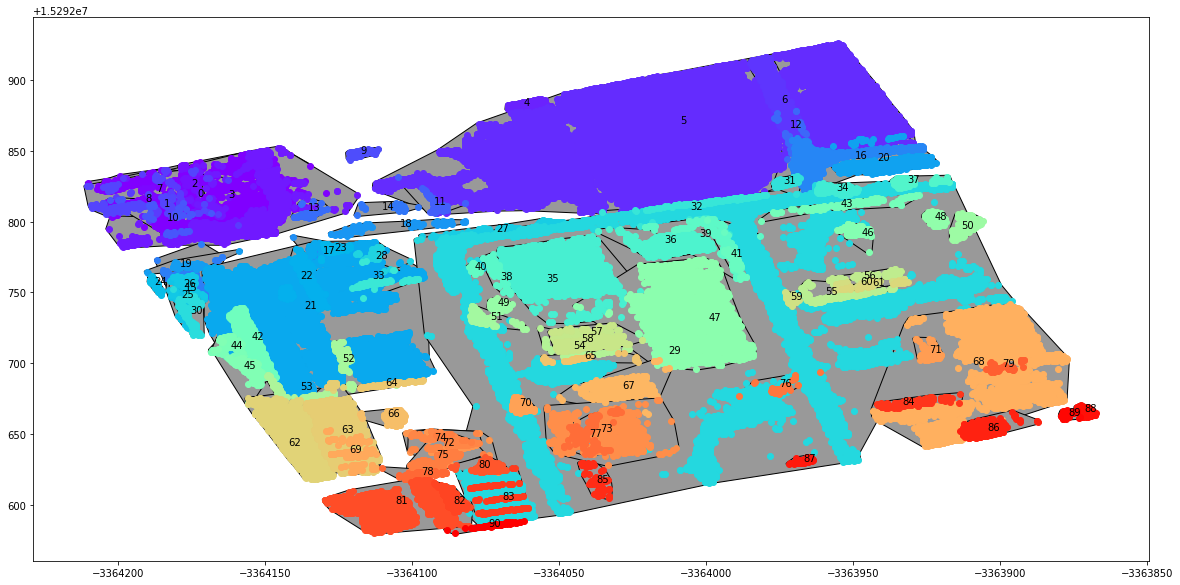

In [278]:
colors=cm.rainbow(np.linspace(0, 1, num_clusters_cleaned))
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
Polygons=[]
for i in range(num_clusters_cleaned):
    plt.scatter(-coords_clusters[i][:,0],-coords_clusters[i][:,1],color=colors[i])
    concave_hull, edge_points = alpha_shape(-coords_clusters[i][:,0:2],alpha=0.01)
    polygon_coords=np.array(concave_hull.exterior.coords.xy)[:,:].T
    #plt.plot(polygon_coords[:,0],polygon_coords[:,1],'or')
    Polygons.append(polygon_coords)
    plot_polygon(ax,concave_hull.buffer(1))
    #Text annotation
    polygon_coords=np.array(concave_hull.exterior.coords.xy)[:,:].T
    xann,yann=np.mean(polygon_coords[:,0]),np.mean(polygon_coords[:,1])
    plt.annotate(str(i),(xann,yann))
plt.show()

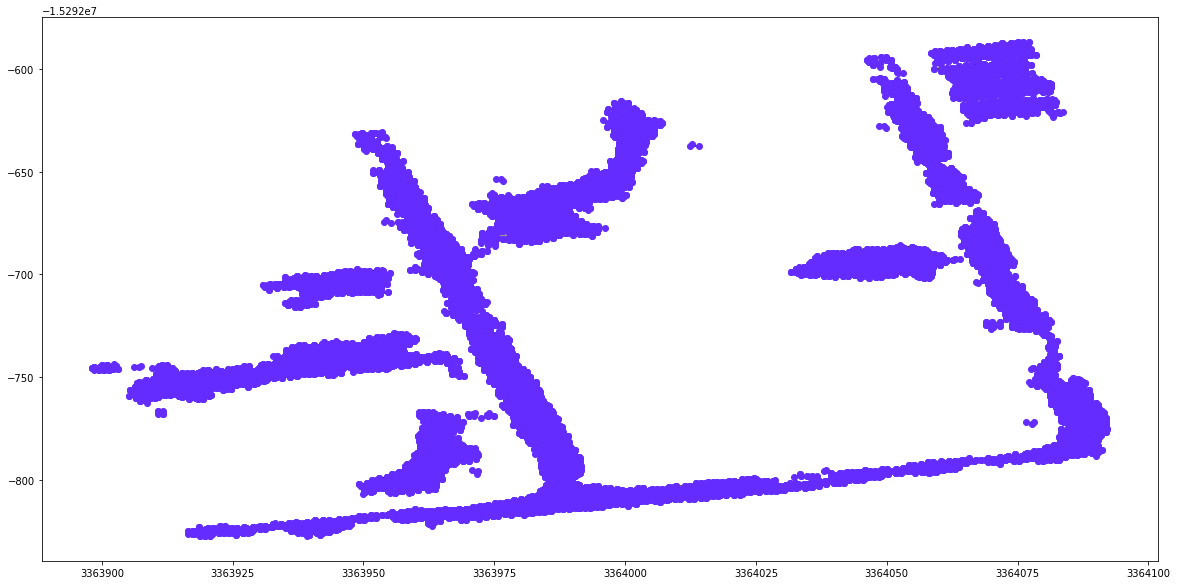

In [287]:
i=29
colors=cm.rainbow(np.linspace(0, 1, num_clusters_cleaned))
new_points=coords_clusters[i][:,0:2]
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
i=5
concave_hull, edge_points = alpha_shape(new_points,alpha=1)
plot_polygon(ax,concave_hull)
#plt.plot(new_points[:,0],new_points[:,1],'o')
plt.scatter(np.array(edge_points)[:,0][:,0],np.array(edge_points)[:,0][:,1],color=colors[i])
plt.show()